In [1]:
filename = 'record/澄闪.csv'
output_filename = 'output/澄闪.png'
targets = {
#     operator: (marker, markersize, color)
    '澄闪': ('*', 48, 'red'),
#     '老鲤': ('o', 48, 'pink'),
    '其他':   ('o', 24, 'yellow')
}

# marker reference
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html

In [2]:
# Common
def contains_chinese(s):
    for c in s:
        if '\u4e00' <= c <= '\u9fa5':
            return True
    return False

def input_file(filename):
    parsed_lines = []
    with open(filename, encoding='utf-8-sig') as f:
        for line in f.readlines():
            parsed_line = []
            parts = line.split(',')
            for part in parts:
                p = part.strip()
                if p.isdigit():
                    parsed_line.append(int(p))
                elif len(p) > 0:
                    parsed_line.append(p)
            parsed_lines.append(parsed_line)
    return parsed_lines

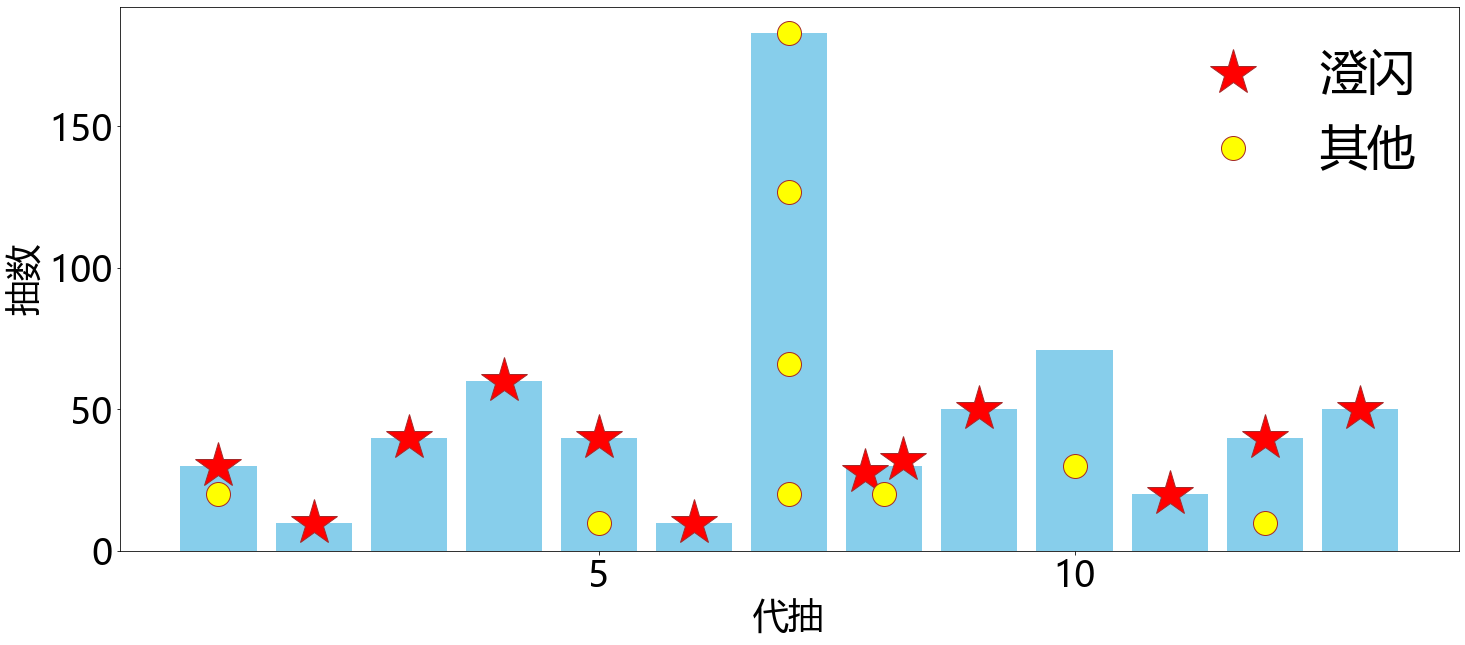

In [3]:
# Plot figure

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']

def parse(lines):
    index = {operator: [] for operator in targets}
    
    summed_lines = []
    for lineno, line in enumerate(lines):
        accumulated = 0
        for part in line:
            if type(part) == int:
                accumulated += int(part)
            elif part in targets:
                coord = (lineno, accumulated)
                if len(index[part]) > 0 and coord == index[part][-1]:
                    index[part][-1] = (lineno - 0.2, accumulated - 2)
                    index[part].append((lineno + 0.2, accumulated + 2))
                else:
                    index[part].append((lineno, accumulated))
            else:
                coord = (lineno, accumulated)
                if len(index['其他']) > 0 and coord == index['其他'][-1]:
                    index['其他'][-1] = (lineno - 0.2, accumulated - 2)
                    index['其他'].append((lineno + 0.2, accumulated + 2))
                else:
                    index['其他'].append((lineno, accumulated))
        summed_lines.append(accumulated)
    return index, summed_lines

index, summed_lines = parse(input_file(filename))
x = [i for i in range(len(summed_lines))]
y = summed_lines

x_ticks = [(i + 1) * 5 - 1 for i in range(len(summed_lines) // 5)]
x_ticklabels = [str((i + 1) * 5) for i in range(len(summed_lines) // 5)]

fig, ax = plt.subplots(figsize=(24, 10), facecolor='white')
ax.bar(x, y, color='skyblue')
# ax.set_facecolor('white')

def plot_6start(label, series, marker, markersize, color):
    a = [x for x, y in series]
    b = [y for x, y in series]
    ax.plot(a, b, label=label, linewidth=0, marker=marker, markersize=markersize, markeredgecolor='brown', color=color, clip_on=False)

for operator in index:
    plot_6start(operator, index[operator], *(targets[operator]))

plt.legend(loc='upper right', fontsize=48, ncol=1, columnspacing=0.0, frameon=False)
    
plt.xlabel("代抽", fontsize=36)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.tick_params(axis='both', labelsize=36)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel("抽数", fontsize=36)
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

fig.savefig(output_filename, transparent=True, facecolor='white')

In [4]:
# Collect basic statistics

def count_boss(lines):
    return len(lines)

def count_successful_boss(lines):
    count = 0
    for line in lines:
        flag = False
        for operator in targets:
            if operator in line:
                flag = True
                break
        if flag:
            count += 1
    return count

def count_total(lines):
    count = 0
    for line in lines:
        for part in line:
            if type(part) == int:
                count += part
    return count

def count_multiple(lines):
    batches = []
    batch = []
    
    for line in lines:
        if len(batch) > 0:
            batches.append(batch)
            batch = []
        for part in line:
            if type(part) == int:
                if len(batch) > 0:
                    batches.append(batch)
                    batch = []
            else:
                batch.append(part)
    if len(batch) > 0:
        batches.append(batch)
        batch = []
    
    ret= {}
    for batch in batches:
        k = len(batch)
        if k not in ret:
            ret[k] = 0
        ret[k] += 1
    return ret    

def count_6star(lines):
    count = 0
    for line in lines:
        for part in line:
            if type(part) == str:
                count += 1
    return count

def count_6star_up(lines):
    count = 0
    for line in lines:
        for part in line:
            if part in targets:
                count += 1
    return count

In [5]:
lines = input_file(filename)
print ('Boss:', count_boss(lines))
print ('Successful Boss: %d' % (count_successful_boss(lines)))
print ('Total Recruit: %d' % (count_total(lines)))
print ('Multiple 6 Star:', count_multiple(lines))
print ('6 Star: %d' % (count_6star(lines)))
print ('6 Star rate: %.2f%%' % (100 * count_6star(lines) / count_total(lines)))
print ('6 Star (Up): %d' % (count_6star_up(lines)))
print ('6 Star (Up) rate: %.2f%%' % (100 * count_6star_up(lines) / count_total(lines)))
print ('6 Star (Up) in 6 Star: %.2f%%' % (100 * count_6star_up(lines) / count_6star(lines)))

Boss: 13
Successful Boss: 11
Total Recruit: 634
Multiple 6 Star: {1: 19, 2: 1}
6 Star: 21
6 Star rate: 3.31%
6 Star (Up): 12
6 Star (Up) rate: 1.89%
6 Star (Up) in 6 Star: 57.14%


In [6]:
import numpy as np
from statsmodels.stats.weightstats import DescrStatsW

def line_to_count(line):
    count = 0
    gold = 0
    up = 0
    for part in line:
        if type(part) == int:
            count += part;
        else:
            gold += 1
        if part in targets:
            up += 1;
    return count, gold / count, up / count

def lines_to_list(lines):
    counts = []
    golds = []
    ups = []
    for line in lines:
        ret = line_to_count(line)
        counts.append(ret[0])
        golds.append(ret[1])
        ups.append(ret[2])
    return counts, golds, ups

def calc_stat(lines):
    counts, golds, ups = lines_to_list(lines)
    avg_gold = np.average(golds, weights=counts)
    avg_up = np.average(ups, weights=counts)
    stdev = DescrStatsW(ups, weights=counts, ddof=1).std
    return avg_gold, avg_up, stdev

In [7]:
lines = input_file(filename)
avg_gold, avg_up, stdev = calc_stat(lines)
print ('Average gold rate: %.2f%%' % (avg_gold * 100))
print ('Average rate: %.2f%%' % (avg_up * 100))
print ('Standard deviation: %.2f%%' % (stdev * 100))

Average gold rate: 3.31%
Average rate: 1.89%
Standard deviation: 2.25%
